In [426]:
import numpy as np
import pandas as pd
import json

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances
from sklearn.metrics import jaccard_similarity_score
from scipy.spatial import distance

from sqlalchemy_utils import database_exists, create_database
from sklearn.cluster import KMeans, MiniBatchKMeans
import psycopg2
from sqlalchemy import create_engine

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [427]:
places = ['socal', 'oc', 'newport', 'newportbeach', 'california', 'ca', 'irvine', 'tustin', 'orangecounty','missionviejo', 'costamesa', 'orange', 'huntingtonbeach']
others = ['bossbabe', 'fitfam', 'lululemon', 'bestgym', 'bestworkout', 'repost', 'photography', 'love', '2017', 'birthday', 'happybirthday', 'tbt']

In [428]:
def CollectTags(f):
    json_data = open("./SampleSet/"+f+"/"+f+".json")
    j = json.load(json_data)
    json_data.close()
    totalTags = ""
    for i in range(len(j)):
        if 'tags' in j[i].keys():
            try:
                listostring=[]
                for b in j[i]['tags']:
                    if (b.lower() in places or b.lower() in others or b == f): continue
                    else: listostring.append(b)
                string = " " + " ".join(listostring)
                #string = " " + " ".join(b for b in j[i]['tags'] if (b.lower() not in places or b.lower() not in others
                #                       or b == f))
                if ' irvine ' in string: print ("da fuck")
                totalTags += string
            except:
                pass
    return totalTags
        


In [429]:
titles = os.listdir("./SampleSet")
genres = ['HIIT circuit',"HIIT circuit", "Martial Arts", "Kickboxing", "Barre", "Yoga", "Barre", "HIIT circuit", "Yoga",
         "Cycling", "Yoga", "Yoga", "Barre", "Marital Arts", "Kickboxing", "Pilates", "Yoga", "Pilates", "Crossfit", "Crossfit",
         "Yoga", "Barre", "HIIT circuit", "Pilates", "HIIT circuit", "Cycling", "HIIT cicuit", "Kickboxing", "HIIT circuit",
         "Yoga", "Everything", "HIIT circuit", "Marital Arts", "Marital Arts", "HIIT ciruit", "Pilates", "Pilates", "Pilates", 
         "Yoga", "Yoga", "Marital Arts", "Yoga", "Yoga", "Everything", "Yoga", "Marital Arts", "Pilates", "Marital Arts",
         "Yoga", "HIIT circuit", "Cycling", "Yoga", "Yoga", "Yoga"]
studioNames = ['The 12 Life', '3D Fitness', '5 Elements', '9Round',
              'Alkalign Studio', 'Baker Ranch Yoga', 'Bar Method', 
              'Barrys Boot Camp', 'Be The Change Yoga', 'Bike 2 The Beat',
              'Bikram Yoga', 'Caffe Yoga', 'Cardio Barre', 'Carrillo Muay Thai',
              'CKO', 'Club Pilates', 'Core Power', 'Core Reform', 'Cross Fit Insanity',
              'Cross Fit Tustin', 'Ekam Yoga', 'Enerji Barre', 'Fitness On Fire',
              'Fit Pilates Studio', 'Fit Wall', 'Freedom Ride', 'HDX Fit', 'ilovekickboxing.com',
              'Kaia Fit', 'Mixx Yoga', 'Neaumix Fit', 'OC Fit', 'OCK MMA', 'One Jui Jitsu',
              'Orange Theory', 'Pilates On Purpose', 'Pilates Plus Cycle', 'Pure Barre',
              'Radiant Yoga','Ra Yoga', 'Rounder MMA', 'Spectra Yoga', 'Stella Luna Yoga',
              'Studio Fixx', 'Sun Spark Yoga', 'Team Oyama', 'The Haute Room',
              'Total MMA', 'Triad Yoga And Pilates', 'Trim Fitness Studio', 'Union Ryde',
              'Vibes Hot Yoga', 'Wild Side Yoga', 'Yoga Shakti']
hashtags = [CollectTags(f) for f in os.listdir("./SampleSet")]
ranks = [i for i in range(len(hashtags))]
print (titles)
print (len(titles), max([len(hashtag) for hashtag in hashtags]))
#print (hashtags[0])

['12life', '3dfitnessgymoc', '5elementsbruce', '9round', 'alkalignme', 'bakerranchyoga', 'barmethod', 'barrysbootcamp', 'bethechangeyoga', 'bike2thebeattustin', 'bikramyogairvine', 'caffeyoga', 'cardiobarre', 'carrillomuaythai', 'ckonorthtustin', 'clubpilates', 'corepoweryoga', 'corereform', 'crossfitinsanity', 'crossfittustin', 'ekamyoga', 'enerjibarre', 'fitnessonfire', 'fitpilatesstudio', 'fitwall', 'freedomride', 'hdxfit', 'ilovekickboxing', 'kaiafit', 'mixxyoga', 'neaumixfit', 'ocfit', 'ockmma', 'onejiujitsu', 'orangetheoryfitness', 'pilatesonpurpose', 'pilatespluscycle', 'pureempower', 'radianthotyoga', 'rayoga', 'roundersmma', 'spectrayoga', 'stellalunayoga', 'studiofixx', 'sunsparkyoga', 'teamoyama', 'thehauteroom', 'totalmmastudios', 'triadyogaandpilates', 'trimfitnessstudio', 'unionryde', 'vibeshotyoga', 'wildsideyoga', 'yogashaktistudio']
54 124855


In [430]:
savedFrame = pd.DataFrame({'name': titles, 'studioName': studioNames, 'type': genres, 'hashtags': hashtags, 'rank': ranks})

In [431]:
dbname = 'studio_db'
username = 'MeghanFrate'
pswd = 'pizza'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

if not database_exists(engine.url):
    create_database(engine.url)

savedFrame.to_sql('studios', engine, if_exists="replace")

In [432]:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM studios;
"""
data_from_sql = pd.read_sql_query(sql_query,con)

data_from_sql.head()

,index,hashtags,name,rank,studioName,type
0,0,12Nation sundaymood sundayvibes workout fitli...,12life,0,The 12 Life,HIIT circuit
1,1,dedication hardwork fitness irvinefitness ocf...,3dfitnessgymoc,1,3D Fitness,HIIT circuit
2,2,5ElementsBruce VixenShow aerialyogaisfun groi...,5elementsbruce,2,5 Elements,Martial Arts
3,3,9roundbutler workout iamstrong flex fitness f...,9round,3,9Round,Kickboxing
4,4,alkalignforlife alkaligninfinity LosAltos fit...,alkalignme,4,Alkalign Studio,Barre


In [433]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000, min_df=0.3, ngram_range=(1,1))
                                 #min_df=0.2, stop_words='english',
                                 #use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(hashtags)
#matrix of row: places
# (place index, word index), tfidf weight
print(tfidf_matrix.shape)
print(tfidf_matrix[0][0].shape)

CPU times: user 386 ms, sys: 10.4 ms, total: 397 ms
Wall time: 396 ms
(54, 240)
(1, 240)


In [434]:
terms = tfidf_vectorizer.get_feature_names()

In [435]:
dist = 1 - cosine_similarity(tfidf_matrix)
#dist = euclidean_distances(tfidf_matrix)
#dist = 1 - pairwise_distances(tfidf_matrix.todense(), metric = "hamming")
#dist = np.zeros((54, 54))

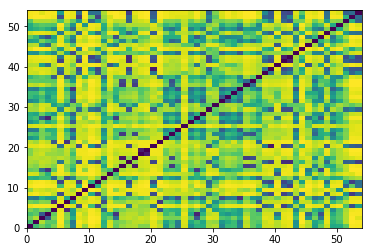

In [436]:
plt.pcolor(dist)

In [437]:
def similarities(M, studio):
    ind = titles.index(studio)
    sims = M[ind][:]
    ordered = [(isim, sim) for isim, sim in enumerate(sims)]
    sortd = sorted(ordered, key=lambda tup: tup[1])
    return sortd

In [438]:
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
s = pd.Series(df.loc['freedomride'])
s[s > 0].sort_values(ascending=False)[:10]

picoftheday    0.422587
nature         0.350268
instagood      0.331589
instadaily     0.309060
travel         0.301564
adventure      0.216832
friends        0.202566
peace          0.197084
cycling        0.169035
thankful       0.168629
Name: freedomride, dtype: float64

In [439]:
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
s = pd.Series(df.loc['unionryde'])
s[s > 0].sort_values(ascending=False)[:10]

cardio              0.474249
fitness             0.328846
sundayfunday        0.284342
letsdothis          0.259047
workout             0.244681
booty               0.219727
cycling             0.214115
noexcuses           0.156814
hustle              0.142743
healthylifestyle    0.142171
Name: unionryde, dtype: float64

In [459]:
dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
s = pd.Series(df.loc['carrillomuaythai'])
s[s > 0].sort_values(ascending=False)[:10]

boxing          0.752285
losangeles      0.462791
success         0.388365
kickboxing      0.123322
fit             0.120263
fitness         0.098170
instagood       0.088185
health          0.057921
bodybuilding    0.053538
muscle          0.051153
Name: carrillomuaythai, dtype: float64

In [440]:
num_clusters = 7

km = KMeans(n_clusters=num_clusters, n_init=100)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


CPU times: user 2.02 s, sys: 6.03 ms, total: 2.03 s
Wall time: 2.02 s


In [441]:
studios = { 'title': titles, 'rank': ranks, 'hashtags': hashtags, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(studios, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
print(frame.head(10))

   rank               title  cluster         genre
1     0              12life        1  HIIT circuit
1     1      3dfitnessgymoc        1  HIIT circuit
3     2      5elementsbruce        3  Martial Arts
3     3              9round        3    Kickboxing
2     4          alkalignme        2         Barre
0     5      bakerranchyoga        0          Yoga
2     6           barmethod        2         Barre
1     7      barrysbootcamp        1  HIIT circuit
0     8     bethechangeyoga        0          Yoga
5     9  bike2thebeattustin        5       Cycling


In [442]:
data_from_sql['clusters'] = clusters
clusternum = (data_from_sql.loc[data_from_sql['name'] == 'mixxyoga'])['clusters'].iloc[0]
print((data_from_sql.loc[29])['clusters'])

0


In [443]:
aa = similarities(dist, "mixxyoga")

print (titles[aa[1][0]])
for bi, b in enumerate(aa):
    if data_from_sql.loc[b[0]]['clusters'] == clusternum:
        continue
    secondsimilar = b[0]
    break
    

print (aa)
print (titles[secondsimilar])

stellalunayoga
[(29, -2.2204460492503131e-16), (42, 0.23723172112250968), (41, 0.2415525801286792), (16, 0.25640893561235634), (20, 0.28349458087484536), (39, 0.29300654840739759), (53, 0.3225045412544586), (11, 0.32641775804844497), (51, 0.34429229706460918), (8, 0.34766162333195016), (10, 0.39676278880835503), (48, 0.42934591871198879), (52, 0.44521874729166067), (5, 0.46473652360379303), (38, 0.50279827563448798), (44, 0.71819151607693488), (30, 0.75046920555106544), (12, 0.75716272608339552), (24, 0.76530224614404008), (37, 0.76719992413556004), (34, 0.77255257871248562), (43, 0.78543384800596694), (50, 0.81512424388222604), (46, 0.81574114117276686), (26, 0.82219628811220979), (31, 0.82426883342957324), (9, 0.82755776818770821), (7, 0.83021820244175182), (32, 0.83837294504436022), (21, 0.84289294781953095), (28, 0.84830273480429796), (1, 0.85471261300321855), (23, 0.8583948078064223), (0, 0.85997334542481785), (22, 0.86764355698528473), (27, 0.88147071202935112), (49, 0.8857118864

In [444]:
aa = sorted(similarities(dist, "mixxyoga"), key=lambda tup: tup[0])
bb = sorted(similarities(dist, "12life"), key=lambda tup: tup[0])
#print(aa)
#print("")
#print(bb)
#print("")
gg=[(aa[i][0], np.sqrt((aa[i][1])**2+(bb[i][1])**2)) for i in range(len(bb))]
ll = sorted(gg, key=lambda tup: tup[1])
#print(ll)
print(titles[ll[2][0]])
print(titles[13])

mixxyoga
carrillomuaythai


In [445]:
frame['cluster'].value_counts()

0    16
1    13
3     9
4     6
2     6
6     2
5     2
Name: cluster, dtype: int64

In [446]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

cluster_names = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_names[i]=""
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_names[i] += terms[ind].split(' ')[0] + " "
        print(' %s' % terms[ind].split(' ')[0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d group:" % i, end='')
    for g in frame.loc[i]['genre'].values.tolist():
        print(' %s,' % g, end='')
    print() #add whitespace
    print() #add whitespace
    
print()

Top terms per cluster:

Cluster 0 words: yoga, yogaeverydamnday, namaste, yogi, meditation, community,

Cluster 0 titles: bakerranchyoga, bethechangeyoga, bikramyogairvine, caffeyoga, corepoweryoga, ekamyoga, mixxyoga, radianthotyoga, rayoga, spectrayoga, stellalunayoga, sunsparkyoga, triadyogaandpilates, vibeshotyoga, wildsideyoga, yogashaktistudio,

Cluster 0 group: Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga, Yoga,

Cluster 1 words: fitness, fit, fitnessmotivation, workout, bootcamp, fitlife,

Cluster 1 titles: 12life, 3dfitnessgymoc, barrysbootcamp, fitnessonfire, fitwall, hdxfit, kaiafit, ocfit, ockmma, onejiujitsu, orangetheoryfitness, studiofixx, trimfitnessstudio,

Cluster 1 group: HIIT circuit, HIIT circuit, HIIT circuit, HIIT circuit, HIIT circuit, HIIT cicuit, HIIT circuit, HIIT circuit, Marital Arts, Marital Arts, HIIT ciruit, Everything, HIIT circuit,

Cluster 2 words: barre, fitness, cardio, workout, pilates, trx,

Cluster 2 ti

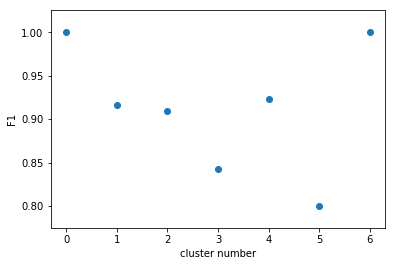

In [465]:
P=np.array([1.,1.,1.,8./10., 1., 2./3., 1.])
R = np.array([1., 11./13., 5./6., 8./9., 6./7., 1., 1.])
plt.scatter(np.arange(0,7), 2.*(P*R)/(P+R) )
plt.xlabel("cluster number")
plt.ylabel("F1")

In [447]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:'blue', 6:'cyan'}

In [448]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = kmeans.cluster_centers_
    labels  = kmeans.labels_

    #print(centers[0])
    #print(np.where(labels==0))
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape
    
    #print(X.shape)
    X = X.toarray()
    #print(X.shape)
    #print(np.asarray(X[np.where(labels == 0)]).shape)
    #print(np.asarray(centers[0].reshape(1,-1)).shape)

    
    #compute variance for all clusters beforehand
    #cl_var = ([distance.cdist(X[np.where(labels == i)], centers[i].reshape(1,-1), 'euclidean') for i in range(m)])
    #cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], centers[i].reshape(1,-1), 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2.) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2.) for i in range(m)]) - const_term

    return(BIC)

In [449]:

bics =[]
for n in range(2, 20):
    kmeans = KMeans(n_clusters=n, n_init=100)
    kmeans.fit(tfidf_matrix)
    
    bics.append(compute_bic(kmeans,tfidf_matrix))
    

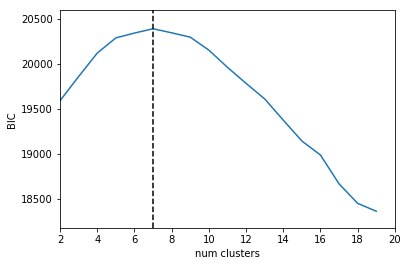

In [450]:
plt.plot(np.arange(2, 20), bics)
plt.plot(7.*np.ones(2), [np.min(bics)*0.99, np.max(bics)*1.01], linestyle = "--", c='black')
plt.xlim([2,20])
plt.ylim([np.min(bics)*0.99, np.max(bics)*1.01])
plt.xlabel("num clusters")
plt.ylabel("BIC")

In [451]:
sil = []
from sklearn.metrics import silhouette_score
for n in range(2, 20):
    m = KMeans(n_clusters=n, n_init=100)
    km.fit(tfidf_matrix)
    label = km.labels_
    sil_coeff = silhouette_score(tfidf_matrix, label, metric='euclidean')
    sil.append(sil_coeff)


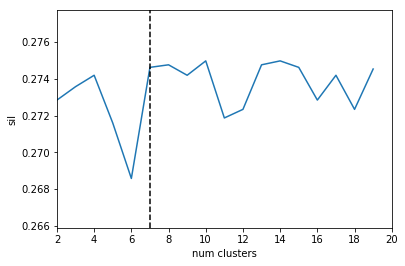

In [452]:
plt.plot(np.arange(2, 20), sil)
plt.plot(7.*np.ones(2), [np.min(sil)*0.99, np.max(sil)*1.01], linestyle = "--", c='black')
plt.xlim([2,20])
plt.ylim([np.min(sil)*0.99, np.max(sil)*1.01])
plt.xlabel("num clusters")
plt.ylabel("sil")

In [453]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

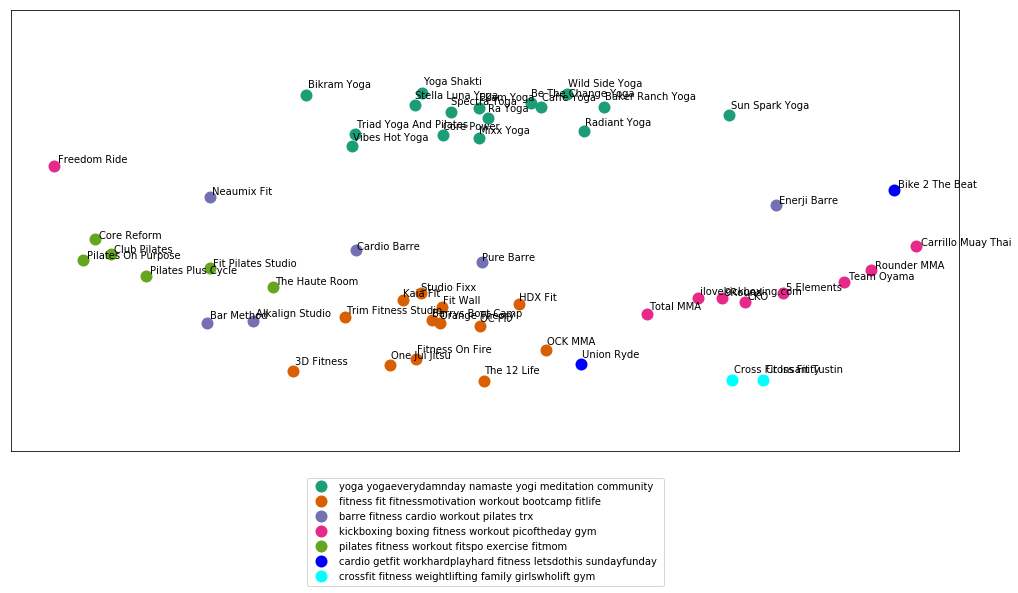

In [466]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=studioNames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    


#ax.set_xlim([-1,1] )
ax.set_ylim([-0.9,1])
#add label in x,y position with the label as the film title
for i in range(len(df)):
    xscalefactor = 1.01 if df.iloc[i]['x'] >0 else 0.99
    yscalefactor = 1.05 if df.iloc[i]['y'] >0 else 0.95
    ax.text(df.iloc[i]['x']*xscalefactor, df.iloc[i]['y']*yscalefactor, df.iloc[i]['title'], size=10)  

#ax.legend(numpoints=1)  #show legend with only 1 point
    
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True,  ncol = 1)
#fig = plt.figure(figsize=(2, 1.25))
#patches = [
#    matplotlib.patches.Patch(color=color, label=label)
#    for label, color in zip(cluster_names, cluster_colors)]
#fig.legend(patches, labels, loc='center', frameon=False)
#plt.show()
#plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

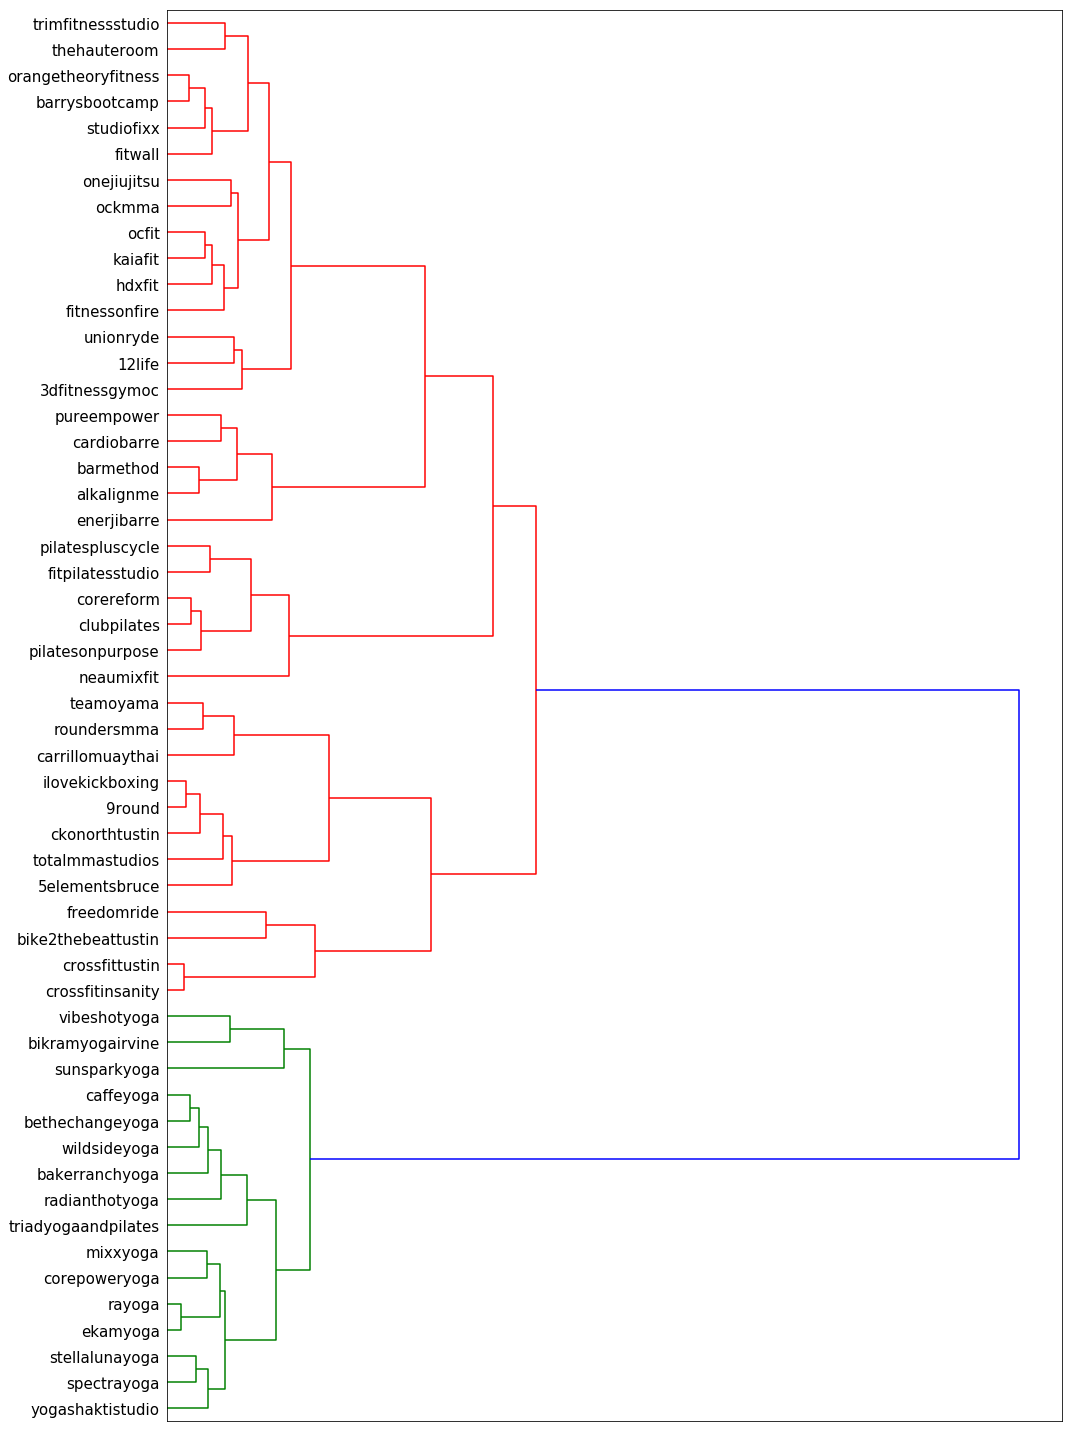

In [455]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, leaf_font_size=15);

#plt.ylabel("classes",fontsize=20)


plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout